# Task 1 

In [1]:
from scipy.io import mmread
import scipy.sparse as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.notebook import tqdm

In [2]:
A = mmread('e20r0000.mtx.gz')
b = mmread('e20r0000_rhs1.mtx.gz')

In [3]:
A.shape

(4241, 4241)

In [4]:
gauss_M = ss.diags(A.diagonal()).tocsr()

residual_df = []
for restart, precond in tqdm(product((5, 20, 40), (None, 'gauss'))):
    residuals = []

    x = ss.linalg.gmres(
        A, 
        b,
        M = gauss_M if precond == 'gauss' else None,
        maxiter = 10000,
        restart = restart,
        callback = lambda r: residuals.append(r), 
        callback_type = 'pr_norm',
        tol=1e-12
    )

    residuals = pd.DataFrame({'residual': residuals})
    residuals['iter'] = np.arange(len(residuals))
    residuals['restart'] = restart
    residuals['precond'] = precond

    residual_df.append(residuals)

residual_df = pd.concat(residual_df)

0it [00:00, ?it/s]

In [6]:
residual_df.to_parquet('e20_residuals.parquet')

In [21]:
residual_df = pd.read_parquet('e20_residuals.parquet')

In [22]:
residual_df['precond'] = residual_df['precond'].astype(str)
residual_df['iter'] = (residual_df['iter'] + 1) / residual_df['restart']

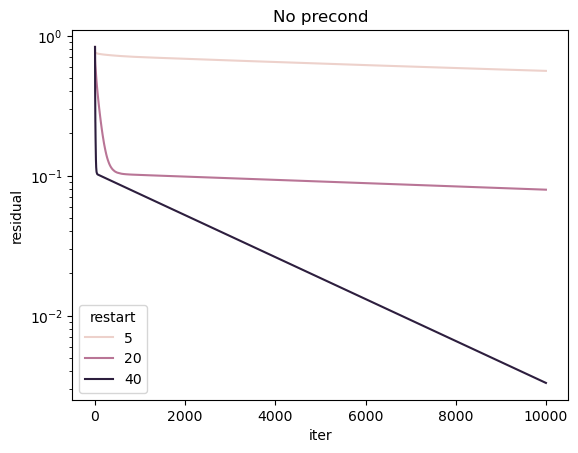

In [23]:
plt.title('No precond')
plt.yscale('log')
sns.lineplot(data=residual_df.query('precond == "None"'), x='iter', y='residual', hue='restart')
plt.show()

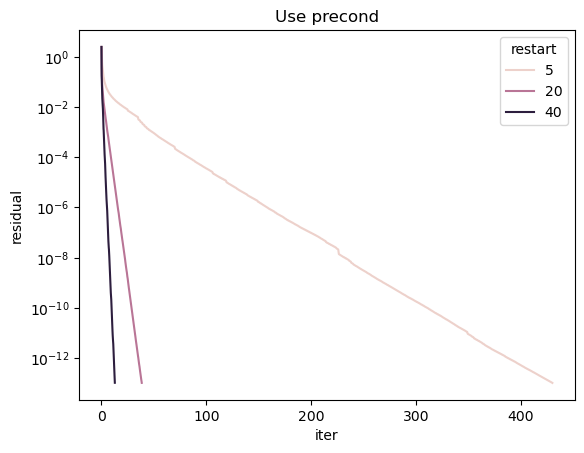

In [24]:
plt.title('Use precond')
plt.yscale('log')
sns.lineplot(data=residual_df.query('(precond == "gauss") & (residual > 1e-13)'), x='iter', y='residual', hue='restart')
plt.show()

In [32]:
cmp_df = pd.merge(
    residual_df\
        .query('precond == "None"')[['residual', 'iter', 'restart']]\
        .rename(columns={'residual': 'NO_residual'}),
    residual_df\
        .query('precond == "gauss"')[['residual', 'iter', 'restart']]\
        .rename(columns={'residual': 'GAUSS_residual'}),
    on=['iter', 'restart']
)

In [35]:
cmp_df['restart'] = cmp_df['restart'].astype(str)

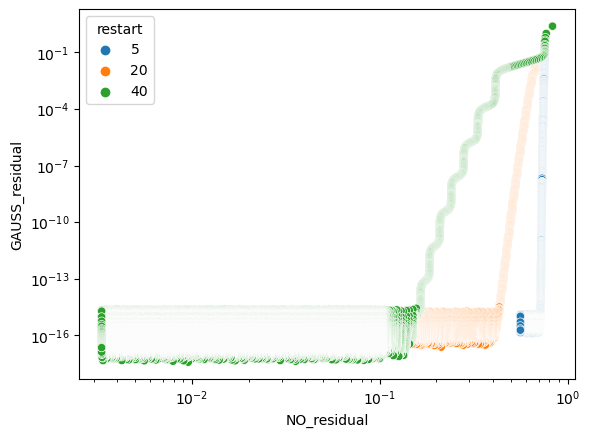

In [36]:
plt.yscale('log')
plt.xscale('log')
sns.scatterplot(
    data=cmp_df, 
    x='NO_residual', 
    y='GAUSS_residual', 
    hue='restart',
)
plt.show()

In [11]:
A = mmread('memplus.mtx.gz')
b = mmread('memplus_rhs1.mtx.gz')
A.shape
gauss_M = ss.diags(A.diagonal()).tocsr()

In [43]:
A.shape

(17758, 17758)

In [12]:
residual_df = []
for restart, precond in tqdm(product((5, 20, 40), (None, 'gauss'))):
    residuals = []

    x = ss.linalg.gmres(
        A, 
        b,
        M = gauss_M if precond == 'gauss' else None,
        maxiter = 10000,
        restart = restart,
        callback = lambda r: residuals.append(r), 
        callback_type = 'pr_norm',
        tol=1e-12
    )

    residuals = pd.DataFrame({'residual': residuals})
    residuals['iter'] = np.arange(len(residuals))
    residuals['restart'] = restart
    residuals['precond'] = precond

    residual_df.append(residuals)

residual_df = pd.concat(residual_df)

0it [00:00, ?it/s]

In [13]:
residual_df.to_parquet('memplus_residuals.parquet')

In [37]:
residual_df = pd.read_parquet('memplus_residuals.parquet')

In [38]:
residual_df['precond'] = residual_df['precond'].astype(str)
residual_df['iter'] = (residual_df['iter'] + 1) / residual_df['restart']

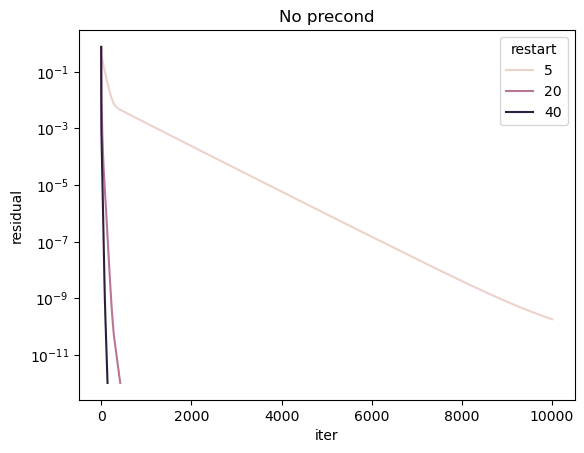

In [39]:
plt.title('No precond')
plt.yscale('log')
sns.lineplot(data=residual_df.query('precond == "None"'), x='iter', y='residual', hue='restart')
plt.show()

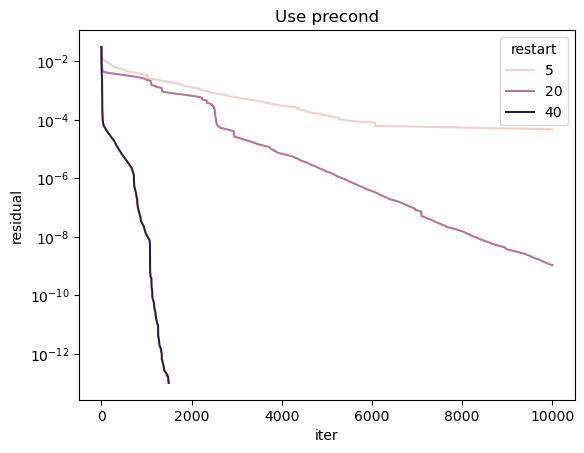

In [40]:
plt.title('Use precond')
plt.yscale('log')
sns.lineplot(data=residual_df.query('(precond == "gauss") & (residual > 1e-13)'), x='iter', y='residual', hue='restart')
plt.show()

In [41]:
cmp_df = pd.merge(
    residual_df\
        .query('precond == "None"')[['residual', 'iter', 'restart']]\
        .rename(columns={'residual': 'NO_residual'}),
    residual_df\
        .query('precond == "gauss"')[['residual', 'iter', 'restart']]\
        .rename(columns={'residual': 'GAUSS_residual'}),
    on=['iter', 'restart']
)
cmp_df['restart'] = cmp_df['restart'].astype(str)

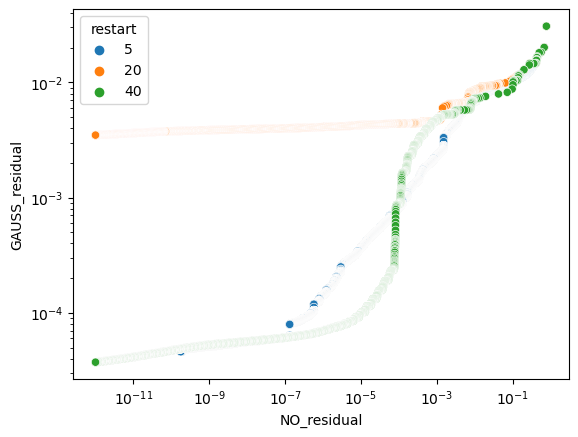

In [42]:

plt.yscale('log')
plt.xscale('log')
sns.scatterplot(
    data=cmp_df, 
    x='NO_residual', 
    y='GAUSS_residual', 
    hue='restart',
)
plt.show()

# Task 2

In [44]:
from sparse_cholesky import sparse_cholesky

In [45]:
from numba import njit
@njit
def cholesky(A): 
    L = np.zeros_like(A)
    n = len(A)

    for i in range(n):
        L[i, i] = np.sqrt(A[i, i] - np.sum(L[i, :i] ** 2))
        
        for j in range(n):
            L[j, i] = (A[j, i] - L[i, :i] @ L[j, :i]) / L[i, i]

    return L 


In [46]:
np.random.seed(42)
n = 100
I = ss.eye(n)
K = ss.diags([-1, 2, -1], offsets=[-1, 0, 1], shape=(n, n)).toarray()
A = ss.kron(I, K) + ss.kron(K, I)

x = np.random.random(n ** 2)
b = A @ x

In [47]:
residuals = []
x = ss.linalg.cg(
    A, 
    b,
    callback = lambda x: residuals.append(np.linalg.norm(A @ x - b)),
    tol=1e-6
)

In [48]:
M = 

/home/denis/miniconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [ ]:
residuals_precond = []
x = ss.linalg.cg(
    A, 
    b,
    callback = lambda x: residuals_precond.append(np.linalg.norm(A @ x - b)),
    M=M,
    maxiter=len(residuals)
)

In [ ]:

plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('residual')
plt.plot(range(len(residuals)), residuals, label='no preconditioning')
plt.plot(range(len(residuals_precond)), residuals_precond, label='preconditioning')
plt.legend()

plt.show()

# Task 3

Lanczos iteration